In [176]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

data = pd.read_csv('Hospital.csv')
data.drop(columns=[col for col in data.columns if 'unnamed' in col.lower()], inplace=True)
colors = ['skyblue', 'lightcoral']

data['Image'] = data.LLM.apply(lambda x: True if "image" in x.lower() else False)
data['Image'] = data['Image'].astype(bool)
data['LLM'] = data.apply(
    lambda row: row['LLM'] + " (One-shot)" if row['Prompt'] == "LTNER/GPT-NER" else row['LLM'] + " (Zero-shot)" if row['Prompt'] == "Normal" else row['LLM'],
    axis=1
)


In [177]:

data.fillna("None", inplace=True)

/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_24825/2152455746.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.fillna("None", inplace=True)


In [178]:
data.isnull().sum()

LLM                      0
False Positives          0
False Negatives          0
Incorrect Extractions    0
Correct Matches          0
Precision                0
Recall                   0
F1score                  0
Accuracy                 0
Parsed                   0
Hospital                 0
Prompt                   0
Distressed               0
Image                    0
dtype: int64

In [179]:
# Ensure F1score is numeric
data['F1score'] = pd.to_numeric(data['F1score'], errors='coerce')
df = data.copy()
#df.drop(data[data["LLM"].str.contains("gpt")].index, inplace=True)
# Group by LLM, Image, and Prompt, and calculate the mean F1score
g = df.groupby(["LLM", "Image", "Prompt"]).F1score.mean().sort_values(ascending=False)
g

LLM                                   Image  Prompt       
gpt-4.1-mini (One-shot)               False  LTNER/GPT-NER    66.600374
gpt-4.1-mini (Zero-shot)              False  Normal           63.048017
gemma327b*ImageInput* (Zero-shot)     True   Normal           51.452168
llama3.170b (One-shot)                False  LTNER/GPT-NER    40.565449
llama3.170b (Zero-shot)               False  Normal           39.905849
mistral(24b) (Zero-shot)              False  Normal           31.392371
mistral(24b) (One-shot)               False  LTNER/GPT-NER    30.183561
NuExtract:4B                          False  None             27.890795
gemma327b*ImageInput* (One-shot)      True   LTNER/GPT-NER    27.526899
mistral(24b)*ImageInput* (Zero-shot)  True   Normal           23.392344
gpt-4.1-mini*ImageInput* (One-shot)   True   LTNER/GPT-NER    21.134443
gpt-4.1-mini*ImageInput* (Zero-shot)  True   Normal           20.127479
gemma327b (One-shot)                  False  LTNER/GPT-NER    17.203308
gemma

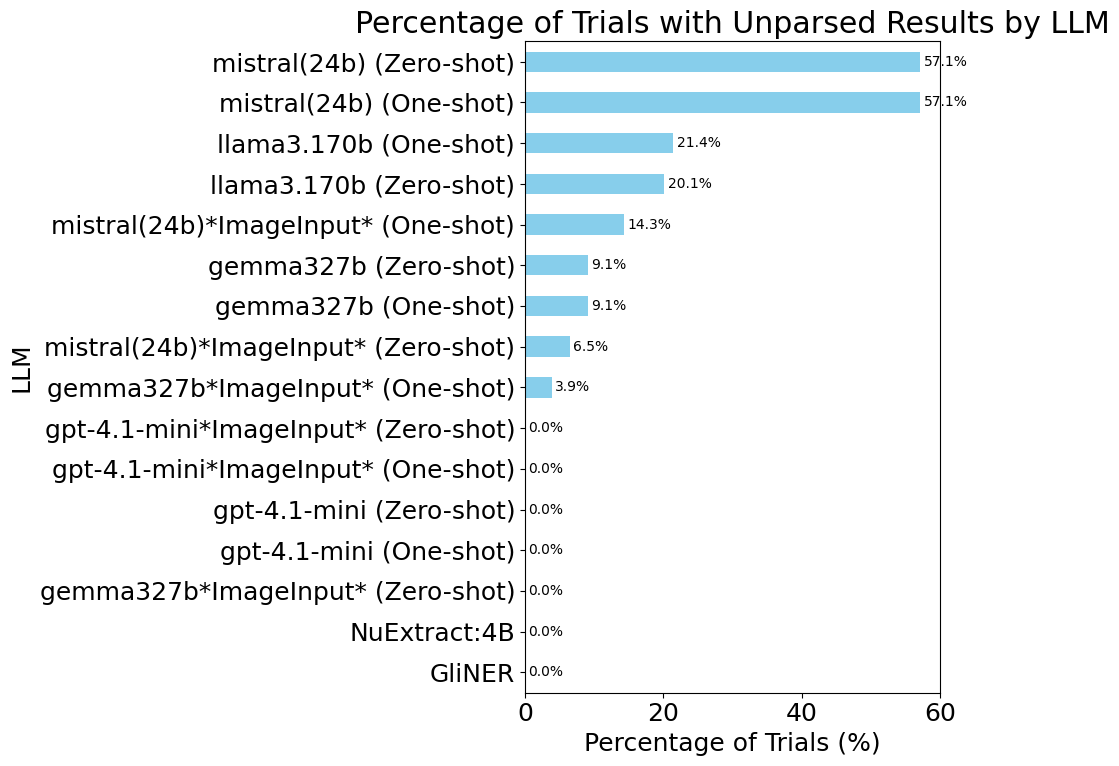

In [180]:
# Calculate percentage of unparsed results by LLM
unparsed_counts = data.loc[data["Parsed"] == False].LLM.value_counts()
total_counts = data.LLM.value_counts()
unparsed_percentages = (unparsed_counts / total_counts * 100).fillna(0)

# Sort by percentage for better visualization
unparsed_percentages = unparsed_percentages.sort_values(ascending=True)

ax = unparsed_percentages.plot(kind='barh', color=colors[0], figsize=(10, 8))
plt.title("Percentage of Trials with Unparsed Results by LLM")
plt.xlabel("Percentage of Trials (%)")
plt.ylabel("LLM")

# Add percentage labels on bars
for i, (model, percentage) in enumerate(unparsed_percentages.items()):
    ax.text(percentage + 0.5, i, f'{percentage:.1f}%', 
           va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [181]:
data.Hospital.value_counts()
data["Error Rate"] = data["Hospital"]

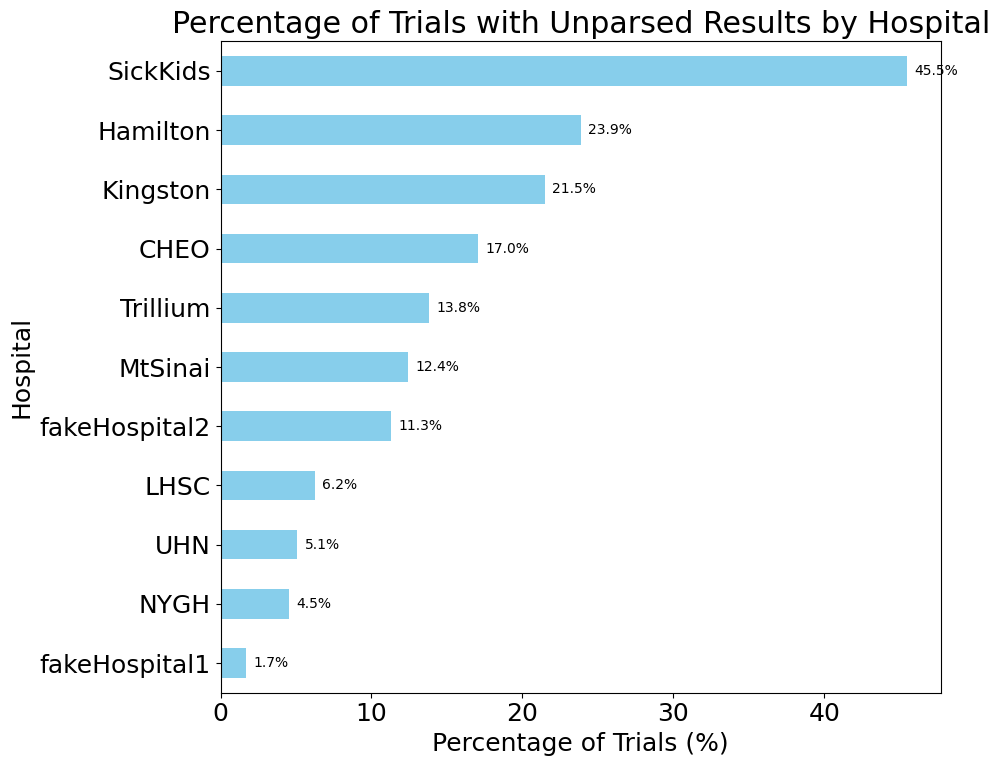

In [182]:
# Calculate percentage of unparsed results by Hospital
unparsed_counts_hospital = data.loc[data["Parsed"] == False].Hospital.value_counts()
total_counts_hospital = data.Hospital.value_counts()
unparsed_percentages_hospital = (unparsed_counts_hospital / total_counts_hospital * 100).fillna(0)

# Sort by percentage for better visualization
unparsed_percentages_hospital = unparsed_percentages_hospital.sort_values(ascending=True)

ax = unparsed_percentages_hospital.plot(kind='barh', color=colors[0], figsize=(10, 8))
plt.title("Percentage of Trials with Unparsed Results by Hospital")
plt.xlabel("Percentage of Trials (%)")
plt.ylabel("Hospital")

# Add percentage labels on bars
for i, (hospital, percentage) in enumerate(unparsed_percentages_hospital.items()):
    ax.text(percentage + 0.5, i, f'{percentage:.1f}%', 
           va='center', ha='left', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# F1 scores for all LLM models with image vs text indicator

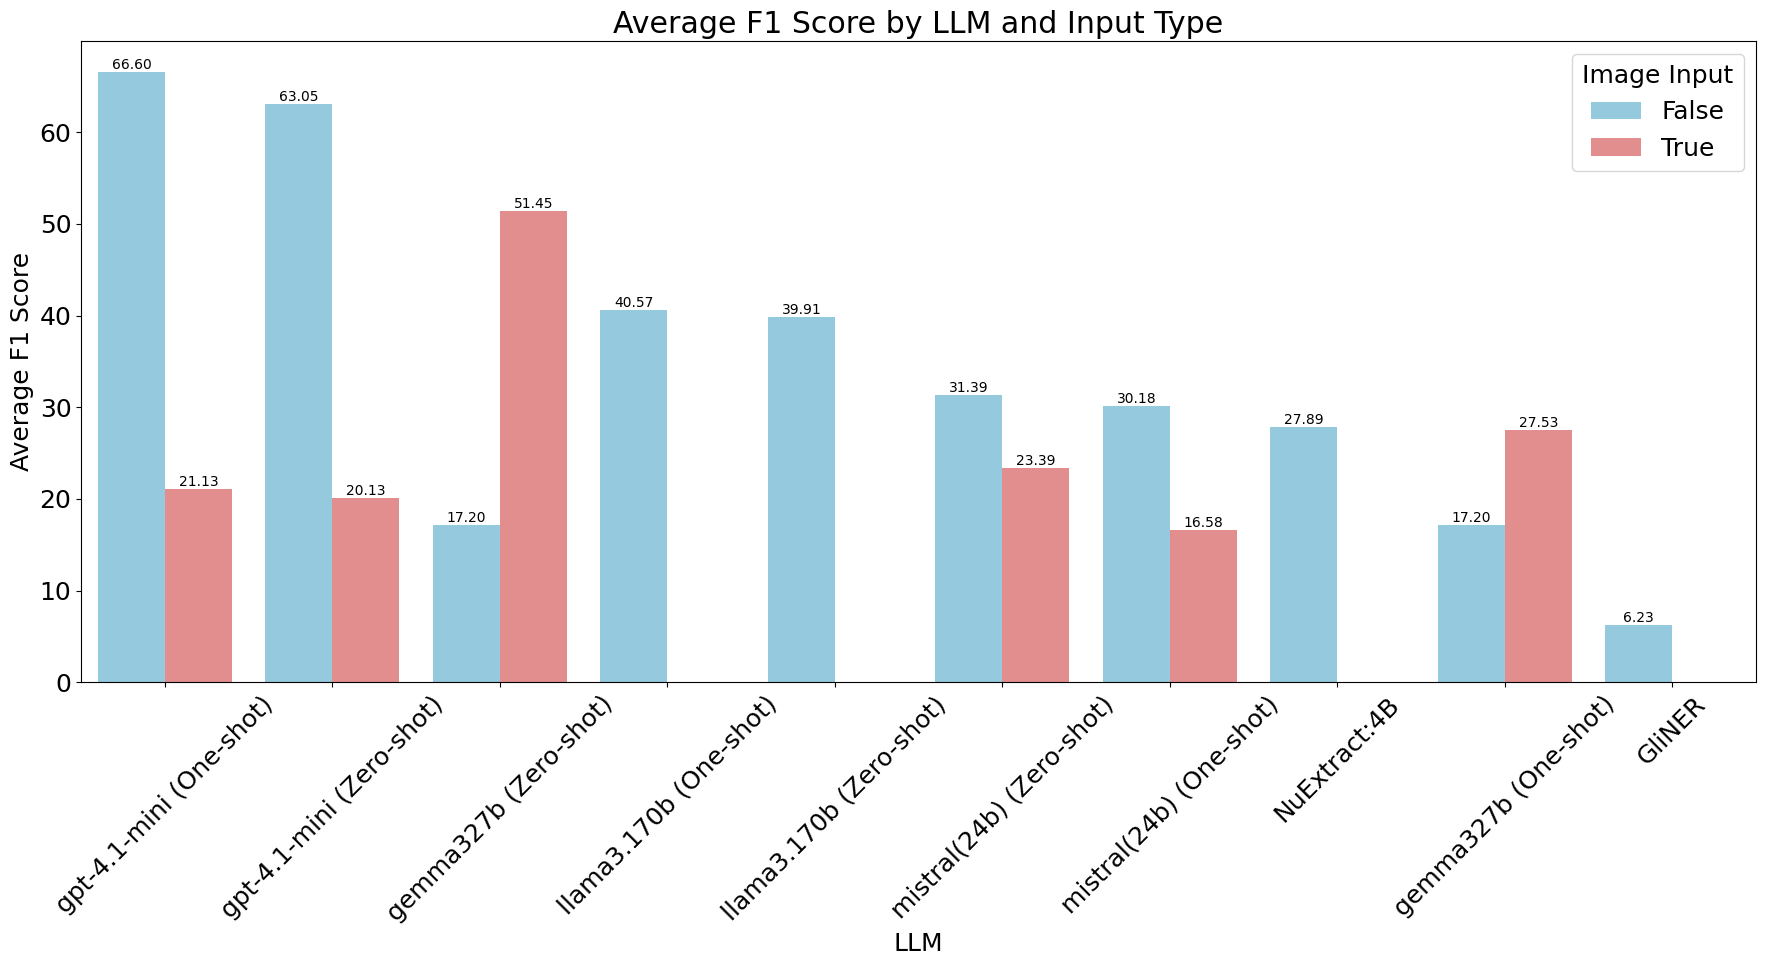

In [183]:
df = data.copy()
df['LLM'] = df['LLM'].apply(lambda x: x.replace('*ImageInput*', ""))
inputType = df.groupby(['LLM', 'Image']).F1score.mean().sort_values(ascending=False)
plt.figure(figsize=(18, 10))
bars = sns.barplot(x=inputType.index.get_level_values(0), y=inputType.values, hue=inputType.index.get_level_values(1), palette=colors)
plt.title('Average F1 Score by LLM and Input Type')
plt.xlabel('LLM')
bars.bar_label(bars.containers[0], fmt='%.2f', fontsize=10, color='black')
bars.bar_label(bars.containers[1], fmt='%.2f', fontsize=10, color='black')

plt.ylabel('Average F1 Score')
plt.xticks(rotation=45)
plt.legend(title='Image Input', loc='upper right')
plt.tight_layout()
plt.show()

# Number of false positives and false negatives

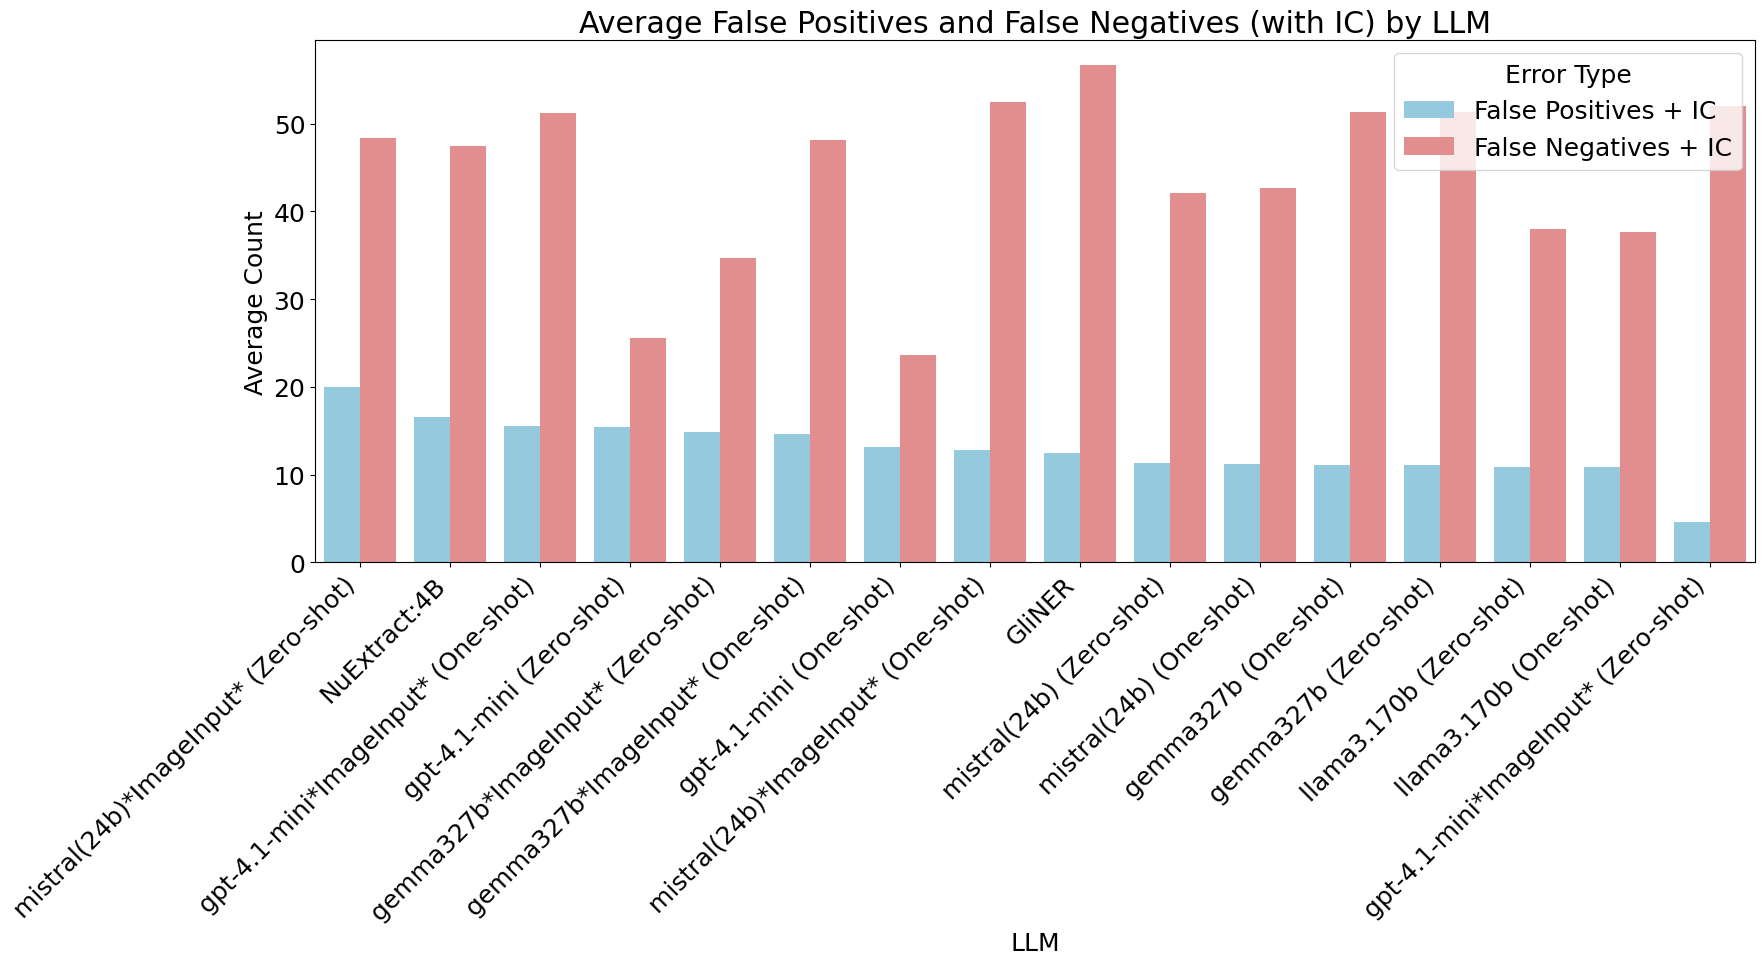

In [184]:
df_errors = data.copy()

# Convert relevant columns to numeric
df_errors['False Positives'] = pd.to_numeric(df_errors['False Positives'], errors='coerce')
df_errors['False Negatives'] = pd.to_numeric(df_errors['False Negatives'], errors='coerce')
df_errors['Incorrect Extractions'] = pd.to_numeric(df_errors['Incorrect Extractions'], errors='coerce')

# Calculate combined error metrics
df_errors['False Positives + IC'] = df_errors['False Positives'] + df_errors['Incorrect Extractions']
df_errors['False Negatives + IC'] = df_errors['False Negatives'] + df_errors['Incorrect Extractions']

# Group by LLM and calculate mean
error_summary = df_errors.groupby('LLM')[['False Positives + IC', 'False Negatives + IC']].mean().sort_values(by='False Positives + IC', ascending=False)

# Melt the summary for visualization
error_summary_melted = error_summary.reset_index().melt(id_vars='LLM', var_name='Error Type', value_name='Average Count')

# Plot the results
plt.figure(figsize=(18, 10))
sns.barplot(data=error_summary_melted, x='LLM', y='Average Count', hue='Error Type', palette=colors)
plt.title('Average False Positives and False Negatives (with IC) by LLM')
plt.xlabel('LLM')
plt.ylabel('Average Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Image vs text Input

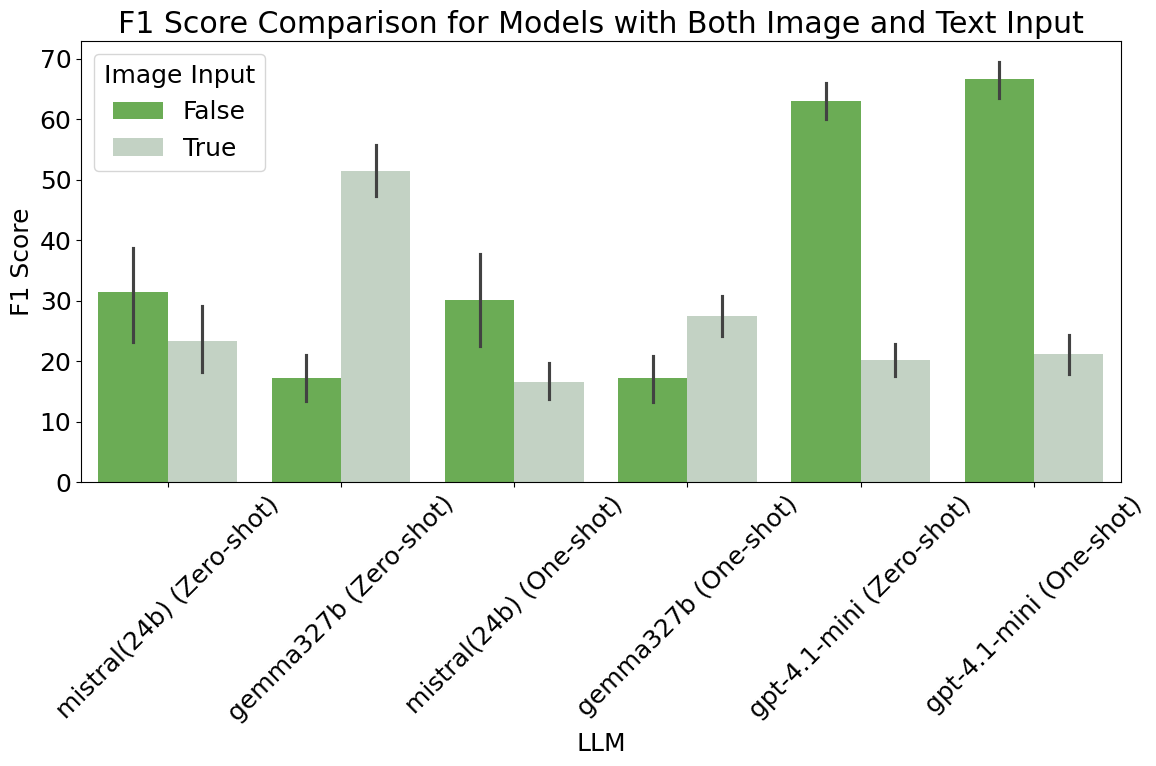

In [185]:
df_image = data.copy()
df_image['LLM_base'] = df_image['LLM'].str.replace('*ImageInput*', '')
llm_counts = df_image.groupby('LLM_base')['Image'].nunique()
models_with_both_inputs = llm_counts[llm_counts > 1].index.tolist()
filtered_df = df_image[df_image['LLM_base'].isin(models_with_both_inputs)]
plt.figure(figsize=(12, 8))
sns.barplot(data=filtered_df, x='LLM_base', y='F1score', hue='Image', palette=["#64bb46", "#c1d4c2"])
plt.title('F1 Score Comparison for Models with Both Image and Text Input')
plt.xlabel('LLM')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.legend(title='Image Input')
plt.tight_layout()
plt.show()

# Precision and Recall by model

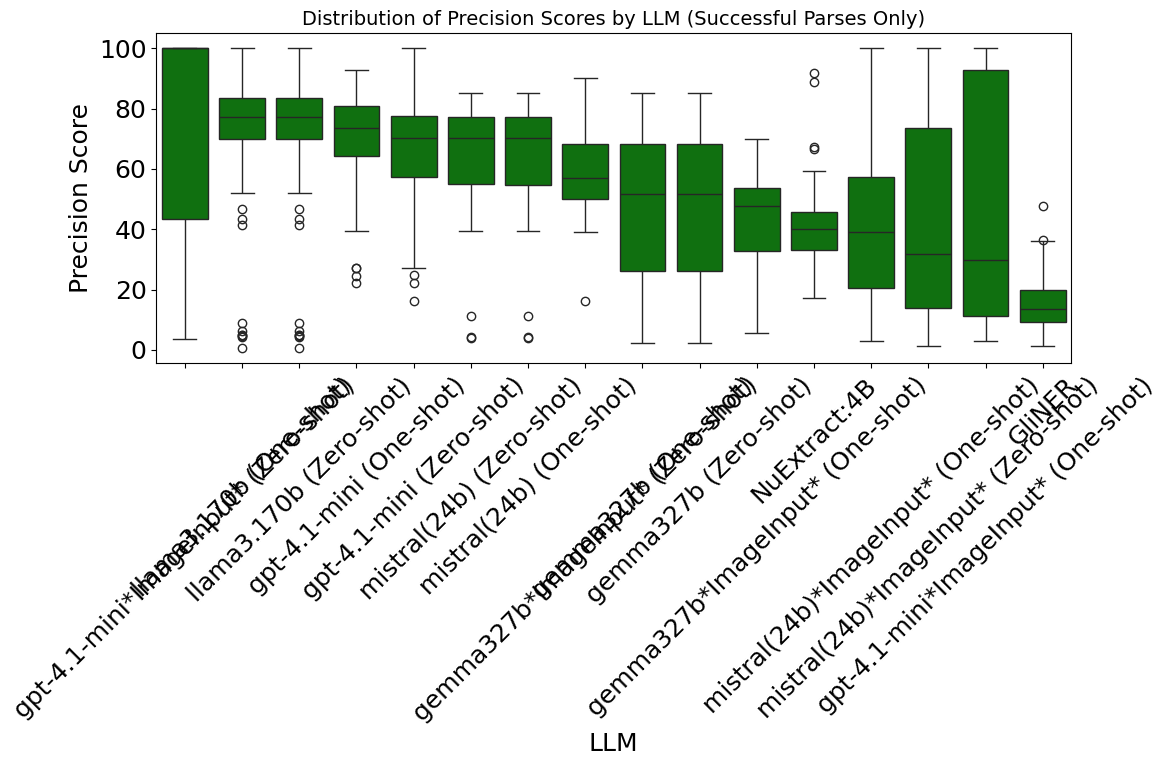

In [186]:
d = data.copy()
d['Precision'] = pd.to_numeric(d['Precision'], errors='coerce')

# Filter out rows where Parsed is False or Precision is 0/NaN for better visualization
d_filtered = d[(d['Parsed'] != False) & (d['Precision'] > 0) & (d['Precision'].notna())]
prompt_order_precision = d_filtered.groupby('LLM')['Precision'].median().sort_values(ascending=False).index
plt.figure(figsize=(12, 8))
sns.boxplot(data=d_filtered, x='LLM', y='Precision', order=prompt_order_precision, color='green')
plt.title('Distribution of Precision Scores by LLM (Successful Parses Only)', fontsize=14)
plt.xlabel('LLM')
plt.ylabel('Precision Score')
plt.xticks(rotation=45)    
plt.tight_layout()
plt.show()

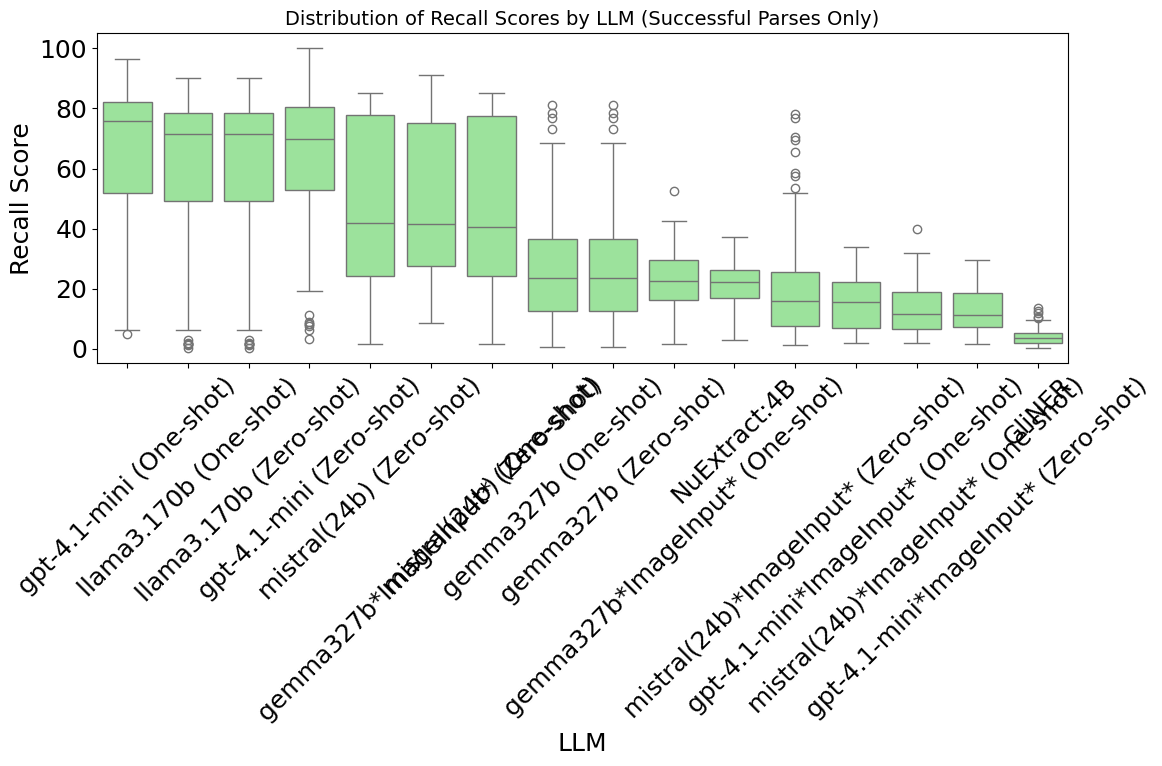

In [187]:
d['Recall'] = pd.to_numeric(d['Recall'], errors='coerce')

# Filter out rows where Parsed is False or Recall is 0/NaN for better visualization
d_filtered_recall = d[(d['Parsed'] != False) & (d['Recall'] > 0) & (d['Recall'].notna())]
prompt_order_recall = d_filtered_recall.groupby('LLM')['Recall'].median().sort_values(ascending=False).index
plt.figure(figsize=(12, 8))
sns.boxplot(data=d_filtered_recall, x='LLM', y='Recall', order=prompt_order_recall, color='lightgreen')
plt.title('Distribution of Recall Scores by LLM (Successful Parses Only)', fontsize=14)
plt.xlabel('LLM')
plt.ylabel('Recall Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Key table

In [188]:
stats = pd.read_csv('Hospital.csv') 
stats.drop(columns=[col for col in stats.columns if 'unnamed' in col.lower()], inplace=True)
stats.drop(index=stats[stats.LLM.str.contains('GLiNER')].index, inplace=True)


In [189]:
stats['Image'] = stats['LLM'].apply(lambda x: True if 'ImageInput' in x else False)
stats['LLM'] = stats['LLM'].apply(lambda x: x.replace('*ImageInput*', ""))


In [190]:
stats.groupby(["Image", "Prompt"]).F1score.mean().sort_values(ascending=False)
stats_pivot = stats.pivot_table(index='Prompt', columns = 'Image', values='F1score', aggfunc='mean')


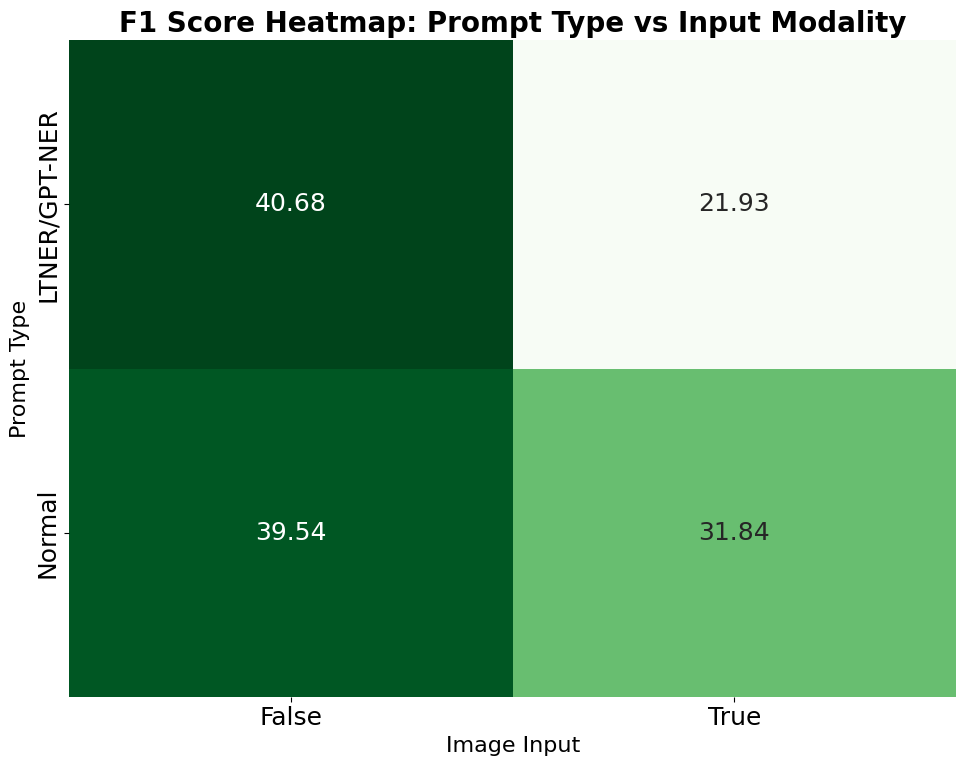

In [191]:

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 18})

sns.heatmap(stats_pivot, annot=True, fmt='.2f', cmap='Greens', cbar = False)
plt.title('F1 Score Heatmap: Prompt Type vs Input Modality', fontsize=20, fontweight='bold')
plt.xlabel('Image Input', fontsize=16)
plt.ylabel('Prompt Type', fontsize=16)
plt.tight_layout()
plt.show()

In [192]:
s = stats.groupby(["LLM",'Image','Prompt']).F1score.mean().sort_values(ascending=False)

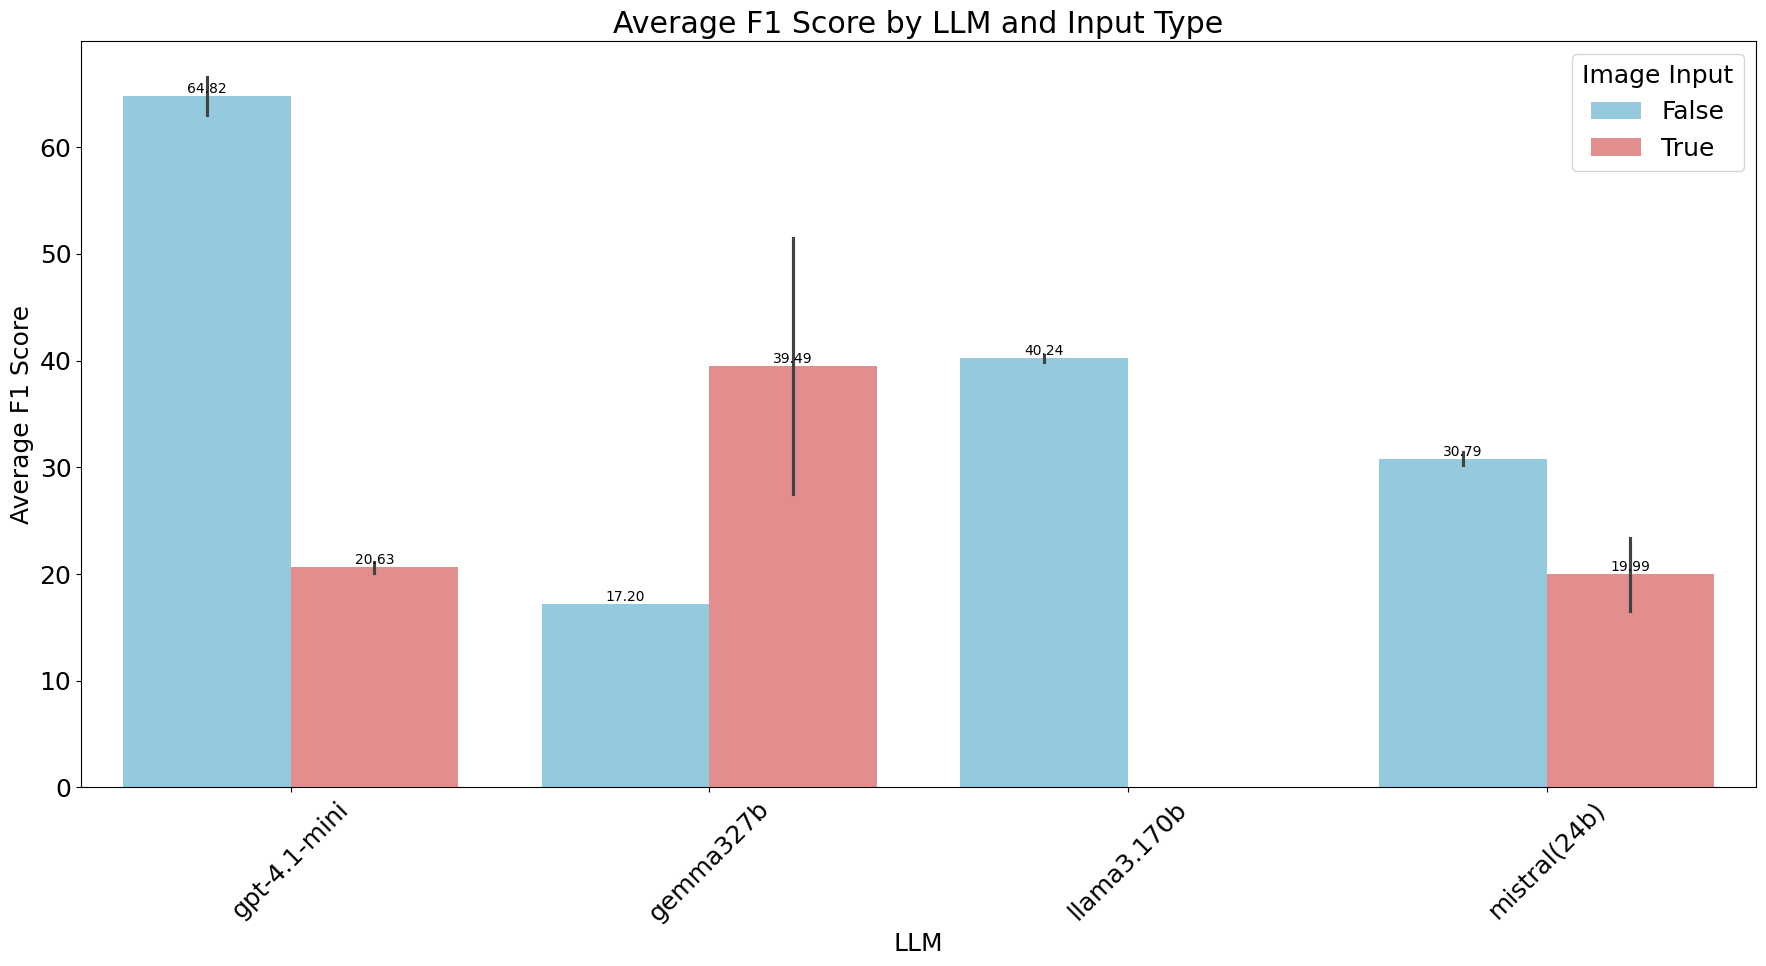

In [193]:
plt.figure(figsize=(18, 10))
bars = sns.barplot(x=s.index.get_level_values(0), y=s.values, hue=s.index.get_level_values(1), palette=colors)
plt.title('Average F1 Score by LLM and Input Type')
plt.xlabel('LLM')
bars.bar_label(bars.containers[0], fmt='%.2f', fontsize=10, color='black')
bars.bar_label(bars.containers[1], fmt='%.2f', fontsize=10, color='black')

plt.ylabel('Average F1 Score')
plt.xticks(rotation=45)
plt.legend(title='Image Input', loc='upper right')
plt.tight_layout()
plt.show()

# Enhanced F1 Score Visualization with Prompt Types

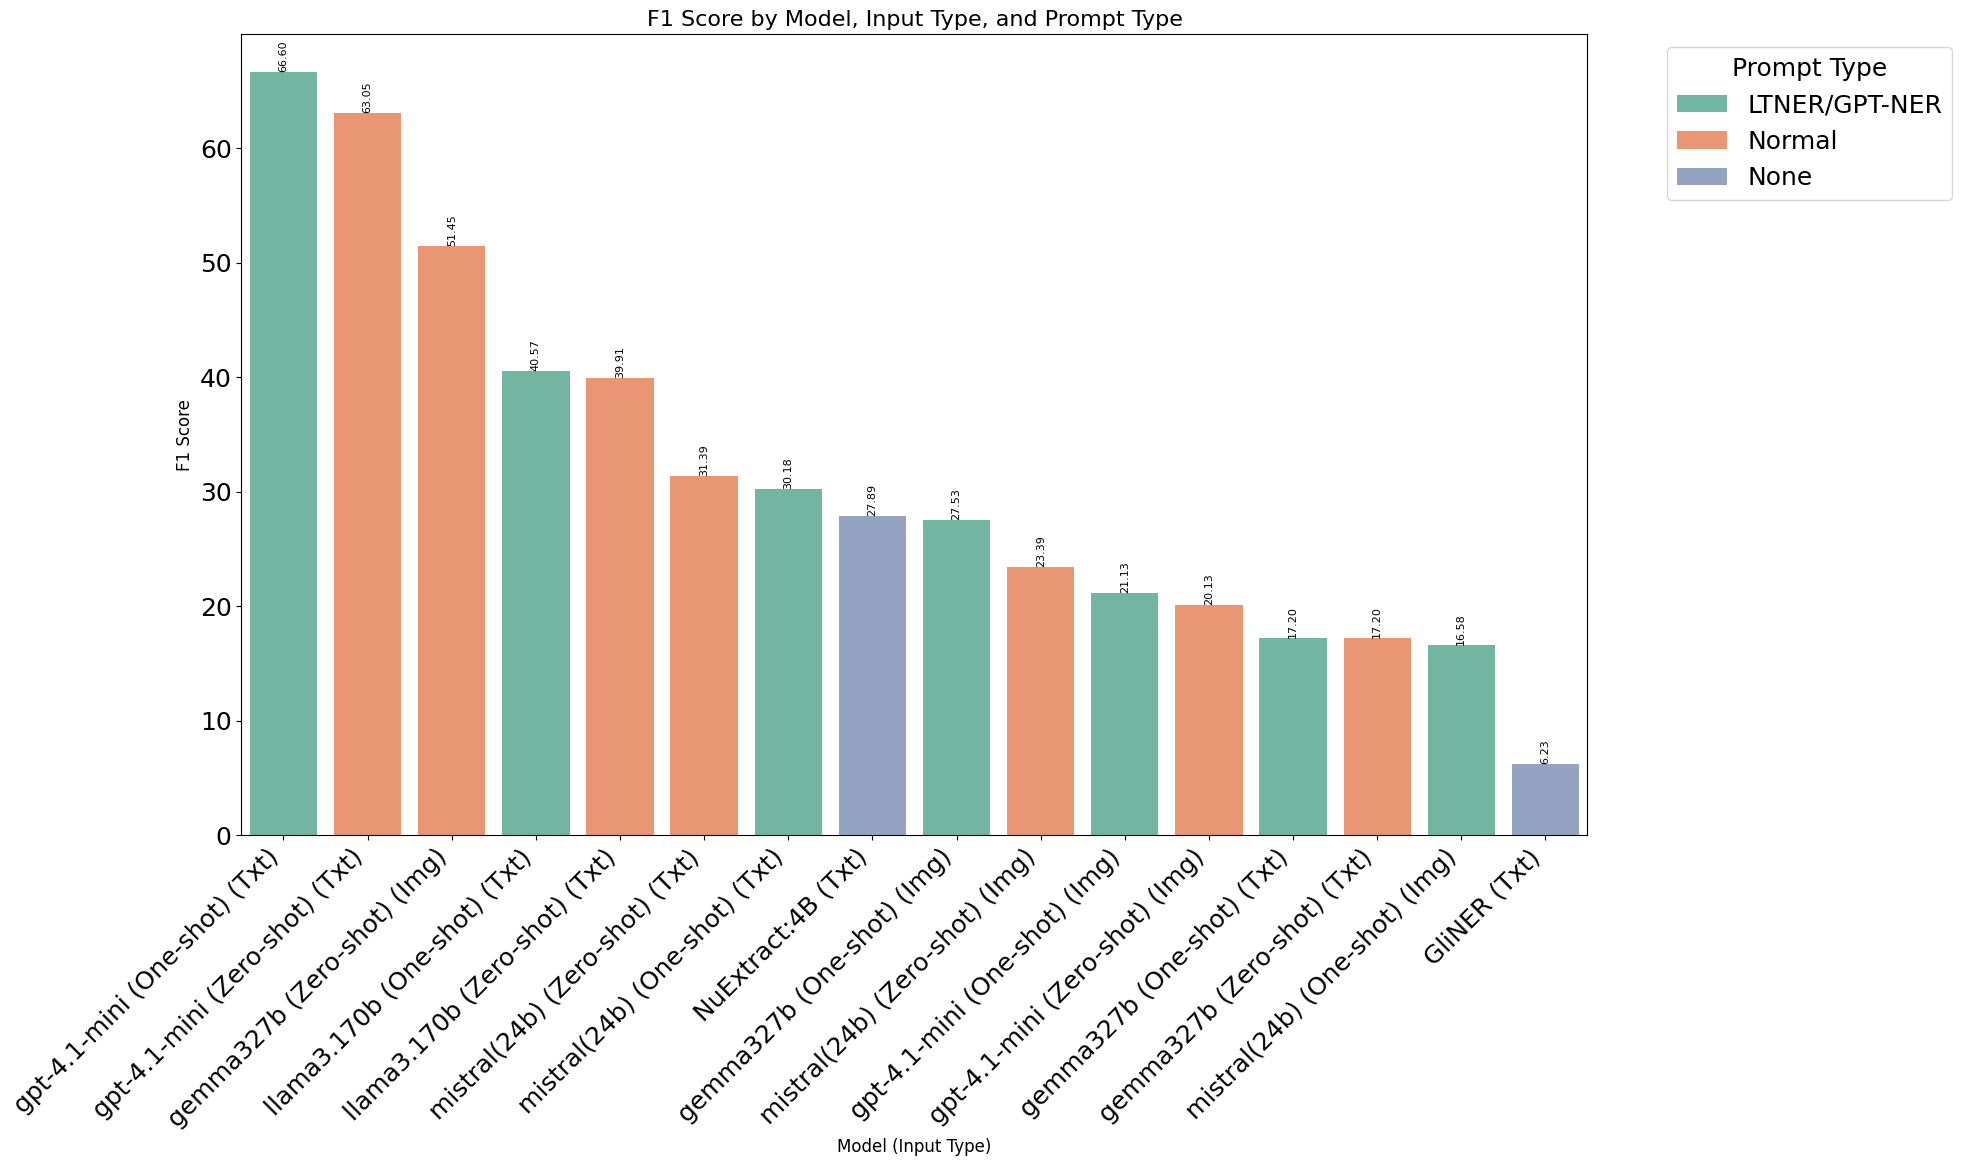

In [194]:
# Create a comprehensive visualization including prompt types
df_enhanced = data.copy()
df_enhanced['Image'] = df_enhanced['LLM'].apply(lambda x: True if 'ImageInput' in x else False)
df_enhanced['LLM_clean'] = df_enhanced['LLM'].str.replace('*ImageInput*', '')

# Group by all three dimensions and calculate mean F1 scores
enhanced_stats = df_enhanced.groupby(['LLM_clean', 'Image', 'Prompt']).F1score.mean().reset_index()
enhanced_stats = enhanced_stats.sort_values('F1score', ascending=False)

# Create a combined identifier for better visualization
enhanced_stats['Model_Input'] = enhanced_stats['LLM_clean'] + ' (' + enhanced_stats['Image'].map({True: 'Img', False: 'Txt'}) + ')'

# Plot with prompt as hue
plt.figure(figsize=(20, 12))
bars = sns.barplot(data=enhanced_stats, x='Model_Input', y='F1score', hue='Prompt', palette='Set2')
plt.title('F1 Score by Model, Input Type, and Prompt Type', fontsize=16)
plt.xlabel('Model (Input Type)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Prompt Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on bars
for container in bars.containers:
    bars.bar_label(container, fmt='%.2f', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

In [195]:
# Create a detailed pivot table for analysis
detailed_pivot = enhanced_stats.pivot_table(
    index='LLM_clean', 
    columns=['Image', 'Prompt'], 
    values='F1score', 
    aggfunc='mean'
)

print("Detailed F1 Score Pivot Table (LLM vs Image Input vs Prompt Type):")
print("=" * 80)
detailed_pivot.round(4)

Detailed F1 Score Pivot Table (LLM vs Image Input vs Prompt Type):


Image                            False                           True   \
Prompt                   LTNER/GPT-NER     None   Normal LTNER/GPT-NER   
LLM_clean                                                                
GliNER                             NaN   6.2277      NaN           NaN   
NuExtract:4B                       NaN  27.8908      NaN           NaN   
gemma327b (One-shot)           17.2033      NaN      NaN       27.5269   
gemma327b (Zero-shot)              NaN      NaN  17.2033           NaN   
gpt-4.1-mini (One-shot)        66.6004      NaN      NaN       21.1344   
gpt-4.1-mini (Zero-shot)           NaN      NaN  63.0480           NaN   
llama3.170b (One-shot)         40.5654      NaN      NaN           NaN   
llama3.170b (Zero-shot)            NaN      NaN  39.9058           NaN   
mistral(24b) (One-shot)        30.1836      NaN      NaN       16.5784   
mistral(24b) (Zero-shot)           NaN      NaN  31.3924           NaN   

Image                              
Prompt                     Normal  
LLM_clean                          
GliNER                        NaN  
NuExtract:4B                  NaN  
gemma327b (One-shot)          NaN  
gemma327b (Zero-shot)     51.4522  
gpt-4.1-mini (One-shot)       NaN  
gpt-4.1-mini (Zero-shot)  20.1275  
llama3.170b (One-shot)        NaN  
llama3.170b (Zero-shot)       NaN  
mistral(24b) (One-shot)       NaN  
mistral(24b) (Zero-shot)  23.3923

In [196]:
# Summary statistics by prompt type
prompt_summary = enhanced_stats.groupby('Prompt').agg({
    'F1score': ['count', 'mean', 'std', 'min', 'max']
}).round(4)

prompt_summary.columns = ['Count', 'Mean_F1', 'Std_F1', 'Min_F1', 'Max_F1']
print("Summary Statistics by Prompt Type:")
print("=" * 50)
prompt_summary

Summary Statistics by Prompt Type:


,Count,Mean_F1,Std_F1,Min_F1,Max_F1
Prompt,,,,,
LTNER/GPT-NER,7,31.3989,17.6359,16.5784,66.6004
None,2,17.0592,15.3181,6.2277,27.8908
Normal,7,35.2174,17.1599,17.2033,63.0480


/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_24825/3708315790.py:100: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_map[combo], hatch=pattern_map[combo],


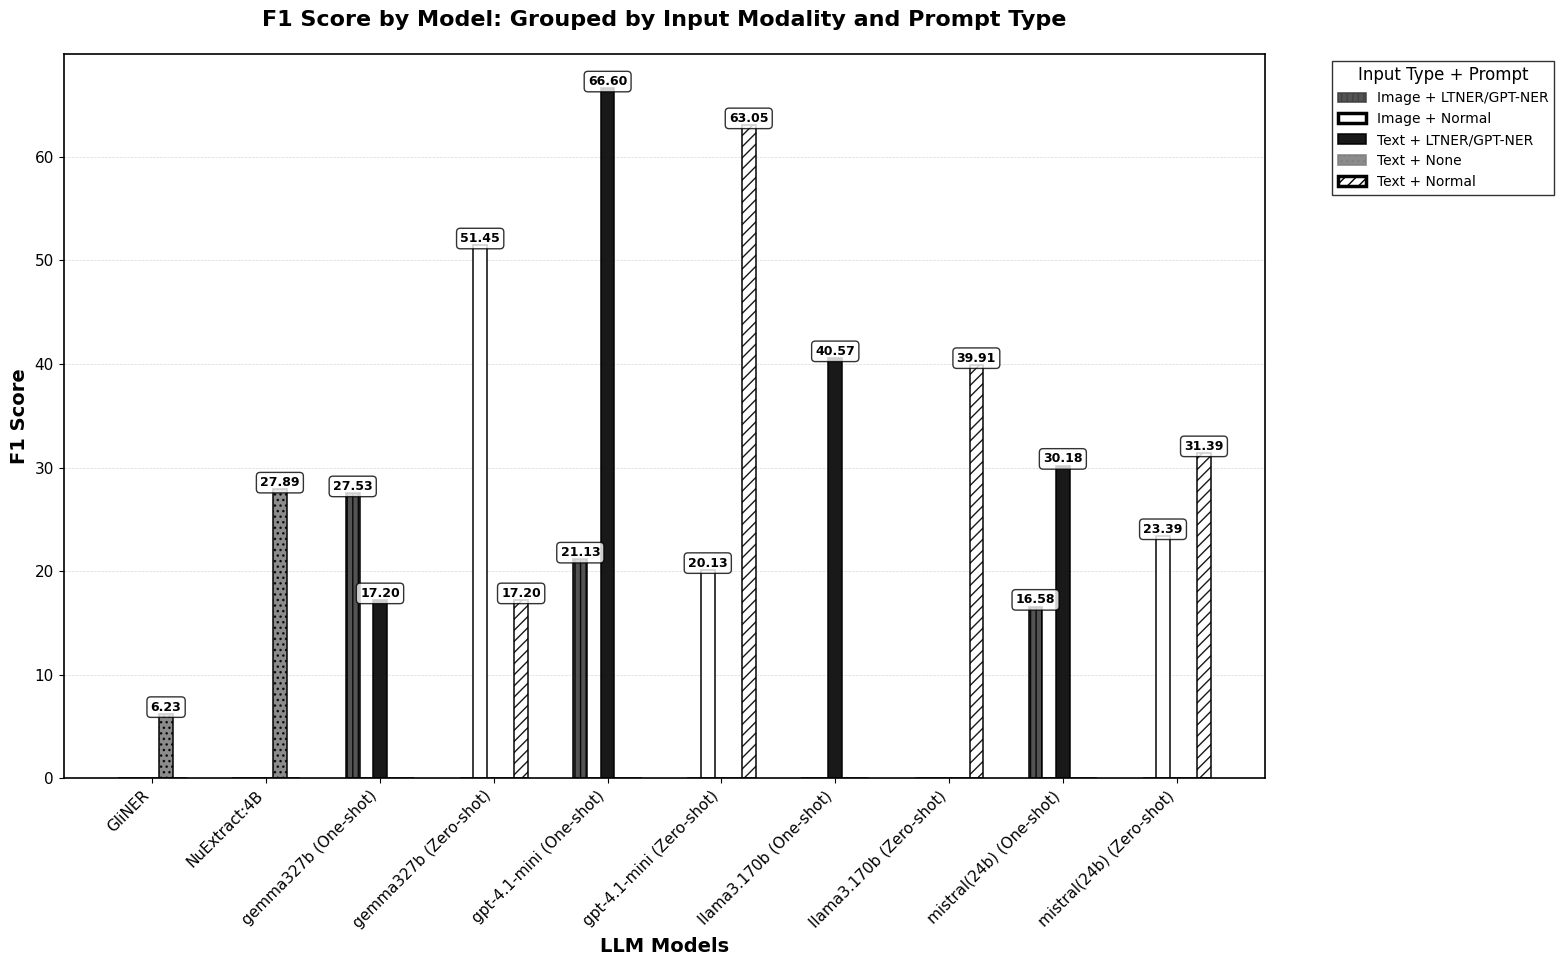


Summary by Input Type and Prompt:
                       count    mean     std
Input_Prompt                                
Image + LTNER/GPT-NER    217  21.929  14.279
Image + Normal           226  31.840  23.089
Text + LTNER/GPT-NER     481  40.677  33.802
Text + None              247  14.384  12.049
Text + Normal            483  39.541  33.077

Legend Reference:
Image + LTNER/GPT-NER: Gray background, Pattern: |||
Image + Normal: White background, Solid
Text + LTNER/GPT-NER: Black background, Solid
Text + None: Gray background, Pattern: ...
Text + Normal: White background, Pattern: ///


In [197]:
# Enhanced grouped bar chart with black and white patterns for academic paper
import matplotlib.patches as mpatches
import numpy as np

# Prepare data for grouped visualization
df_grouped = data.copy()
df_grouped['LLM_clean'] = df_grouped['LLM'].str.replace('*ImageInput*', '')

# Create combined grouping variable
df_grouped['Input_Prompt'] = df_grouped['Image'].map({True: 'Image', False: 'Text'}) + ' + ' + df_grouped['Prompt'].fillna('None')

# Calculate mean F1 scores
grouped_stats = df_grouped.groupby(['LLM_clean', 'Input_Prompt']).F1score.mean().reset_index()
grouped_stats = grouped_stats.sort_values('F1score', ascending=False)

# Create pivot table for easier plotting
pivot_data = grouped_stats.pivot(index='LLM_clean', columns='Input_Prompt', values='F1score')

# Define colors and patterns for each combination (academic paper style)
# Using mix of black, gray, and white backgrounds with contrasting patterns
color_map = {
    'Text + LTNER/GPT-NER': '#000000',    # black
    'Text + Normal': '#ffffff',           # white
    'Text + None': '#808080',             # medium gray
    'Image + LTNER/GPT-NER': '#404040',   # dark gray
    'Image + Normal': '#ffffff',          # white
    'Image + None': '#000000'             # black
}

pattern_map = {
    'Text + LTNER/GPT-NER': '',           # solid black
    'Text + Normal': '///',               # white with diagonal lines
    'Text + None': '...',                 # gray with dots
    'Image + LTNER/GPT-NER': '|||',       # dark gray with vertical lines
    'Image + Normal': '',                  # white with horizontal lines
    'Image + None': '++++'                # black with crosses
}

# Define text colors for visibility on different backgrounds
text_color_map = {
    'Text + LTNER/GPT-NER': 'white',      # white text on black
    'Text + Normal': 'black',             # black text on white
    'Text + None': 'white',               # white text on gray
    'Image + LTNER/GPT-NER': 'white',     # white text on dark gray
    'Image + Normal': 'black',            # black text on white
    'Image + None': 'white'               # white text on black
}

# Create the plot
fig, ax = plt.subplots(figsize=(16, 10))

# Plot bars with patterns
x = np.arange(len(pivot_data.index))
width = 0.12

for i, col in enumerate(pivot_data.columns):
    if col in color_map:
        values = pivot_data[col].fillna(0)
        bars = ax.bar(x + i*width, values, width, 
                     label=col, color=color_map[col], 
                     hatch=pattern_map[col], alpha=0.9, 
                     edgecolor='black', linewidth=1.2)
        
        # Add value labels on bars with appropriate text color
        text_color = text_color_map[col]
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                # Position text slightly above bar for better visibility
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{height:.2f}', ha='center', va='bottom', 
                       fontsize=9, fontweight='bold', color='black',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                edgecolor='black', alpha=0.8))

# Customize the plot for academic style
ax.set_xlabel('LLM Models', fontsize=14, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=14, fontweight='bold')
ax.set_title('F1 Score by Model: Grouped by Input Modality and Prompt Type', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x + width * (len(pivot_data.columns) - 1) / 2)
ax.set_xticklabels(pivot_data.index, rotation=45, ha='right', fontsize=11)
ax.tick_params(axis='y', labelsize=11)

# Create custom legend with patterns - ensuring white backgrounds are visible
legend_elements = []
for combo in pivot_data.columns:
    if combo in color_map:
        # Special handling for white backgrounds to ensure visibility
        if color_map[combo] == '#ffffff':
            # White background with thick black border and clear pattern
            legend_elements.append(
                mpatches.Patch(facecolor='white', hatch=pattern_map[combo], 
                              label=combo, alpha=1.0, 
                              edgecolor='black', linewidth=2.5)
            )
        else:
            # Other colors with standard borders
            legend_elements.append(
                mpatches.Patch(color=color_map[combo], hatch=pattern_map[combo], 
                              label=combo, alpha=0.9, 
                              edgecolor='black', linewidth=1.2)
            )

ax.legend(handles=legend_elements, title='Input Type + Prompt', 
         title_fontsize=12, fontsize=10,
         bbox_to_anchor=(1.05, 1), loc='upper left',
         frameon=True, fancybox=False, shadow=False,
         edgecolor='black', facecolor='white')

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5, color='gray')
ax.set_axisbelow(True)

# Set background to white
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Add border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()

# Print summary statistics
print('\nSummary by Input Type and Prompt:')
print('=' * 50)
summary = df_grouped.groupby('Input_Prompt')['F1score'].agg(['count', 'mean', 'std']).round(3)
print(summary)

# Print color and pattern legend for reference
print('\nLegend Reference:')
print('=' * 30)
for combo in pivot_data.columns:
    if combo in color_map:
        color_desc = 'Black' if color_map[combo] == '#000000' else 'White' if color_map[combo] == '#ffffff' else 'Gray'
        pattern_desc = 'Solid' if pattern_map[combo] == '' else f"Pattern: {pattern_map[combo]}"
        print(f"{combo}: {color_desc} background, {pattern_desc}")

/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_24825/1339713588.py:86: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color=color_map[combo], hatch=pattern_map[combo],


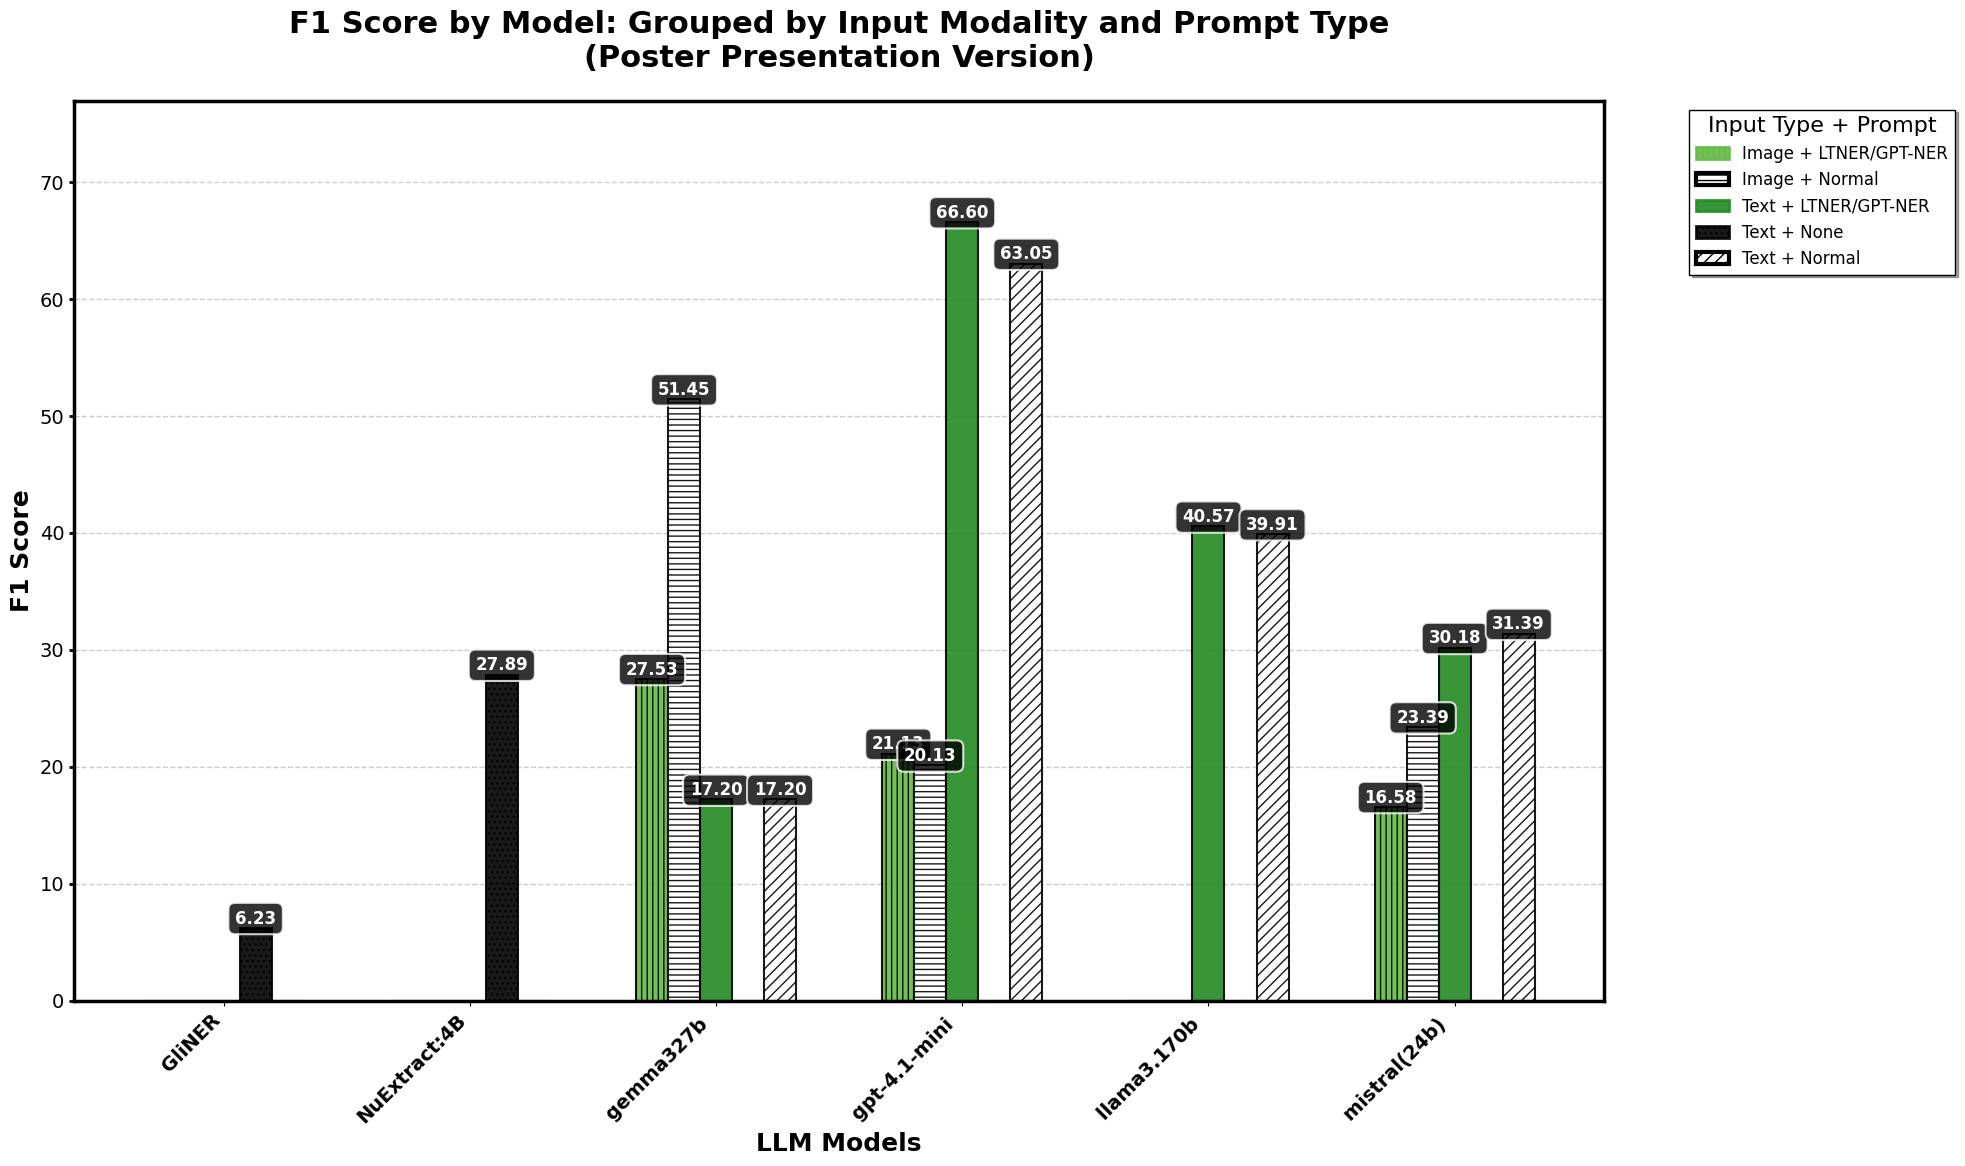


Poster Presentation Color Scheme:
Image + LTNER/GPT-NER: Black, Pattern: |||
Image + Normal: White, Pattern: ---
Text + LTNER/GPT-NER: Forest Green, Solid
Text + None: Black, Pattern: ...
Text + Normal: White, Pattern: ///


In [198]:
# Poster presentation version with green, white, and black colors
import matplotlib.patches as mpatches
import numpy as np

# Prepare data for grouped visualization
df_grouped = data.copy()
df_grouped['LLM_clean'] = df_grouped['LLM'].str.replace('*ImageInput*', '').str.replace("(One-shot)", "").str.replace("(Zero-shot)", "")

# Create combined grouping variable
df_grouped['Input_Prompt'] = df_grouped['Image'].map({True: 'Image', False: 'Text'}) + ' + ' + df_grouped['Prompt'].fillna('None')

# Calculate mean F1 scores
grouped_stats = df_grouped.groupby(['LLM_clean', 'Input_Prompt']).F1score.mean().reset_index()
grouped_stats = grouped_stats.sort_values('F1score', ascending=False)

# Create pivot table for easier plotting
pivot_data = grouped_stats.pivot(index='LLM_clean', columns='Input_Prompt', values='F1score')

# Define green, white, and black color scheme for poster presentation
color_map = {
    'Text + LTNER/GPT-NER': '#228B22',    # forest green
    'Text + Normal': '#ffffff',           # white
    'Text + None': '#000000',             # black
    'Image + LTNER/GPT-NER': '#64bb46',   # lime green
    'Image + Normal': '#ffffff',          # white
    'Image + None': '#006400'             # dark green
}

pattern_map = {
    'Text + LTNER/GPT-NER': '',           # solid forest green
    'Text + Normal': '///',               # white with diagonal lines
    'Text + None': '...',                 # black with dots
    'Image + LTNER/GPT-NER': '|||',       # lime green with vertical lines
    'Image + Normal': '---',              # white with horizontal lines
    'Image + None': '++++'                # dark green with crosses
}

# Create the plot with larger figure size for poster
fig, ax = plt.subplots(figsize=(20, 12))

# Plot bars with patterns
x = np.arange(len(pivot_data.index))
width = 0.13

for i, col in enumerate(pivot_data.columns):
    if col in color_map:
        values = pivot_data[col].fillna(0)
        bars = ax.bar(x + i*width, values, width, 
                     label=col, color=color_map[col], 
                     hatch=pattern_map[col], alpha=0.9, 
                     edgecolor='black', linewidth=1.5)
        
        # Add value labels on bars with contrasting colors
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                # Use white text with black outline for visibility
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{height:.2f}', ha='center', va='bottom', 
                       fontsize=12, fontweight='bold', color='white',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='black', 
                                edgecolor='white', alpha=0.8, linewidth=1.5))

# Customize the plot for poster presentation
ax.set_xlabel('LLM Models', fontsize=18, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=18, fontweight='bold')
ax.set_title('F1 Score by Model: Grouped by Input Modality and Prompt Type\n(Poster Presentation Version)', 
             fontsize=22, fontweight='bold', pad=25)
ax.set_xticks(x + width * (len(pivot_data.columns) - 1) / 2)
ax.set_xticklabels(pivot_data.index, rotation=45, ha='right', fontsize=14, fontweight='bold')
ax.tick_params(axis='y', labelsize=14, width=2)

# Create custom legend with green/white/black theme
legend_elements = []
for combo in pivot_data.columns:
    if combo in color_map:
        # Special handling for white backgrounds
        if color_map[combo] == '#ffffff':
            legend_elements.append(
                mpatches.Patch(facecolor='white', hatch=pattern_map[combo], 
                              label=combo, alpha=1.0, 
                              edgecolor='black', linewidth=3.0)
            )
        else:
            legend_elements.append(
                mpatches.Patch(color=color_map[combo], hatch=pattern_map[combo], 
                              label=combo, alpha=0.9, 
                              edgecolor='black', linewidth=2.0)
            )

ax.legend(handles=legend_elements, title='Input Type + Prompt', 
         title_fontsize=16, fontsize=12,
         bbox_to_anchor=(1.05, 1), loc='upper left',
         frameon=True, fancybox=False, shadow=True,
         edgecolor='black', facecolor='white')

# Add grid for better readability
ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=1.0, color='gray')
ax.set_axisbelow(True)

# Set background to white
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Add thick border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2.5)

# Increase y-axis range slightly for better visibility
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)

plt.tight_layout()
plt.show()

# Print color scheme reference for poster
print('\nPoster Presentation Color Scheme:')
print('=' * 40)
for combo in pivot_data.columns:
    if combo in color_map:
        if color_map[combo] == '#228B22':
            color_desc = 'Forest Green'
        elif color_map[combo] == '#32CD32':
            color_desc = 'Lime Green'
        elif color_map[combo] == '#006400':
            color_desc = 'Dark Green'
        elif color_map[combo] == '#ffffff':
            color_desc = 'White'
        else:
            color_desc = 'Black'
        pattern_desc = 'Solid' if pattern_map[combo] == '' else f"Pattern: {pattern_map[combo]}"
        print(f"{combo}: {color_desc}, {pattern_desc}")

/var/folders/2r/vpjdzw2s7jl5204hqh_k3c9h0000gp/T/ipykernel_24825/3927364412.py:24: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.3'` for the same effect.

  sns.stripplot(data=d_melted, x='LLM', y='Score', hue='Metric',


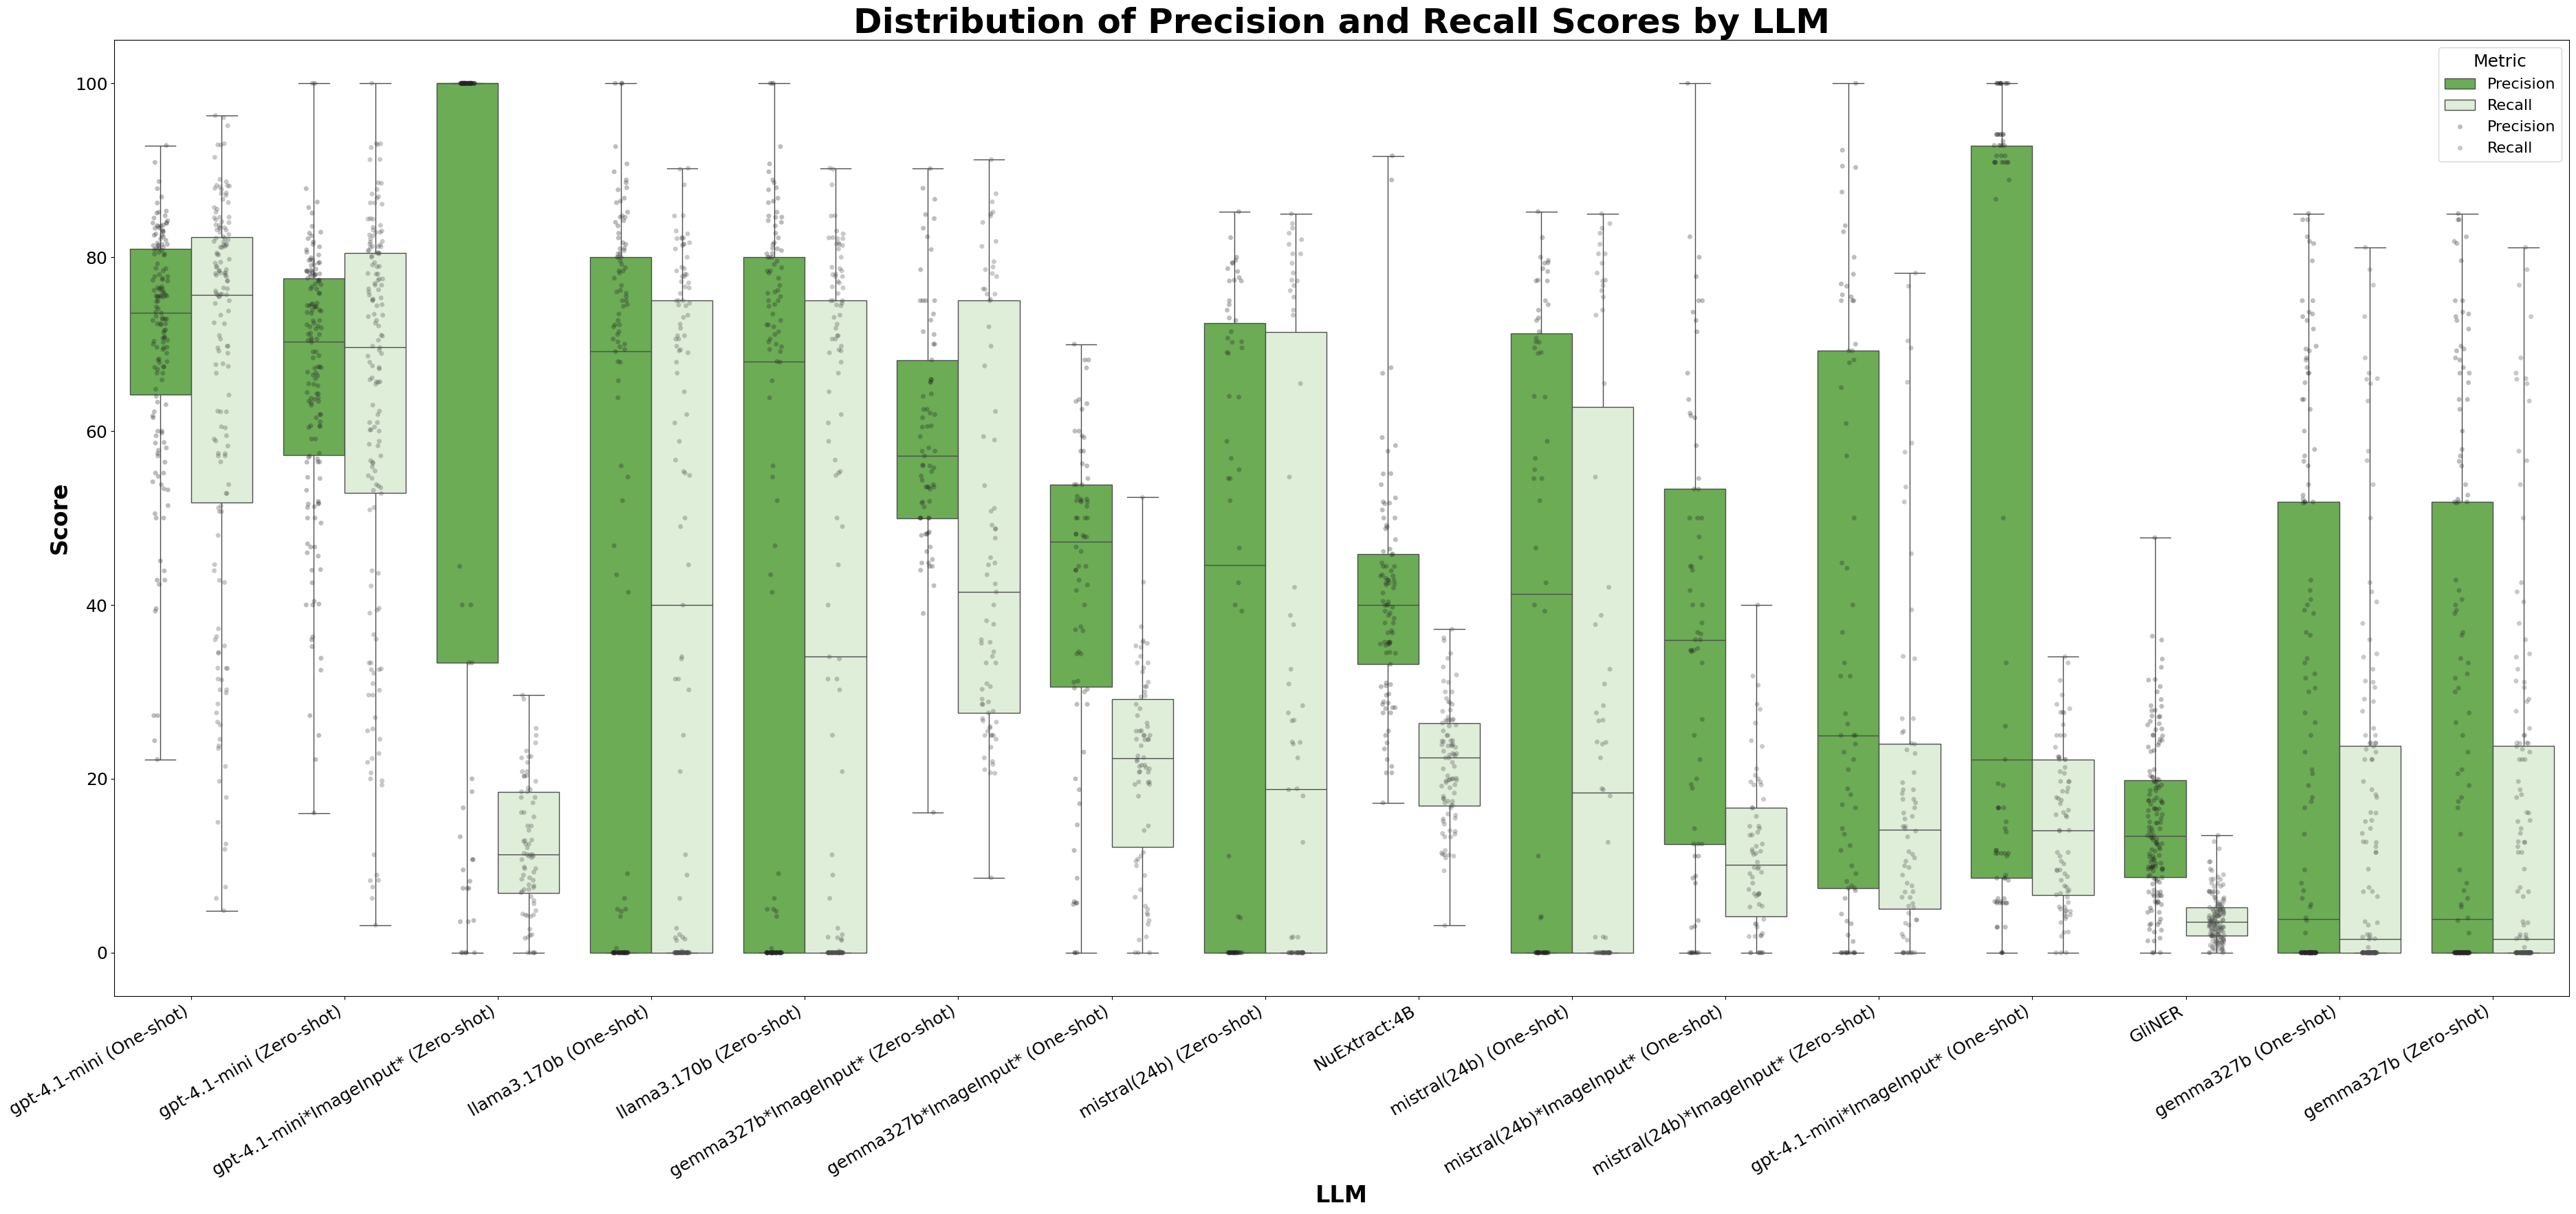

Showing 1654 successful parses out of 1941 total attempts
LLMs ordered by median combined performance (Precision + Recall)


In [199]:
d = data.copy()
d['Precision'] = pd.to_numeric(d['Precision'], errors='coerce')
d['Recall'] = pd.to_numeric(d['Recall'], errors='coerce')

# Filter out failed parses and zero values
d_filtered = d[(d['Parsed'] != False) &  (d['Precision'].notna()) & (d['Recall'].notna())]

if len(d_filtered) > 0:
    # Melt the dataframe to combine Precision and Recall into one column
    d_melted = d_filtered.melt(
        id_vars=['LLM', 'Parsed', 'Image', 'Prompt'], 
        value_vars=['Precision', 'Recall'],
        var_name='Metric', 
        value_name='Score'
    )
    
    # Order LLMs by median combined performance
    llm_order = d_filtered.groupby('LLM')[['Precision', 'Recall']].median().mean(axis=1).sort_values(ascending=False).index
    
    # Create the combined box plot
    plt.figure(figsize=(38, 18))
    sns.boxplot(data=d_melted, x='LLM', y='Score', hue='Metric', 
                order=llm_order, palette=['#64bb46', "#DDF1D6"], whis=(0, 100))
    sns.stripplot(data=d_melted, x='LLM', y='Score', hue='Metric', 
                order=llm_order, color=".3", dodge=True, alpha=0.3, jitter=True)
    plt.title('Distribution of Precision and Recall Scores by LLM', fontsize=36, fontweight='bold')
    plt.xlabel('LLM', fontsize=24, fontweight='bold')
    plt.ylabel('Score', fontsize=24, fontweight='bold')
    plt.xticks(rotation=30, ha='right')
    
    
    # Customize legend
    plt.legend(title='Metric', title_fontsize=18, fontsize=16, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Showing {len(d_filtered)} successful parses out of {len(d)} total attempts")
    print(f"LLMs ordered by median combined performance (Precision + Recall)")
else:
    print("No valid precision/recall data to display")

# Improved F1 Score Visualization - Clean Model Names with Green Color Scheme

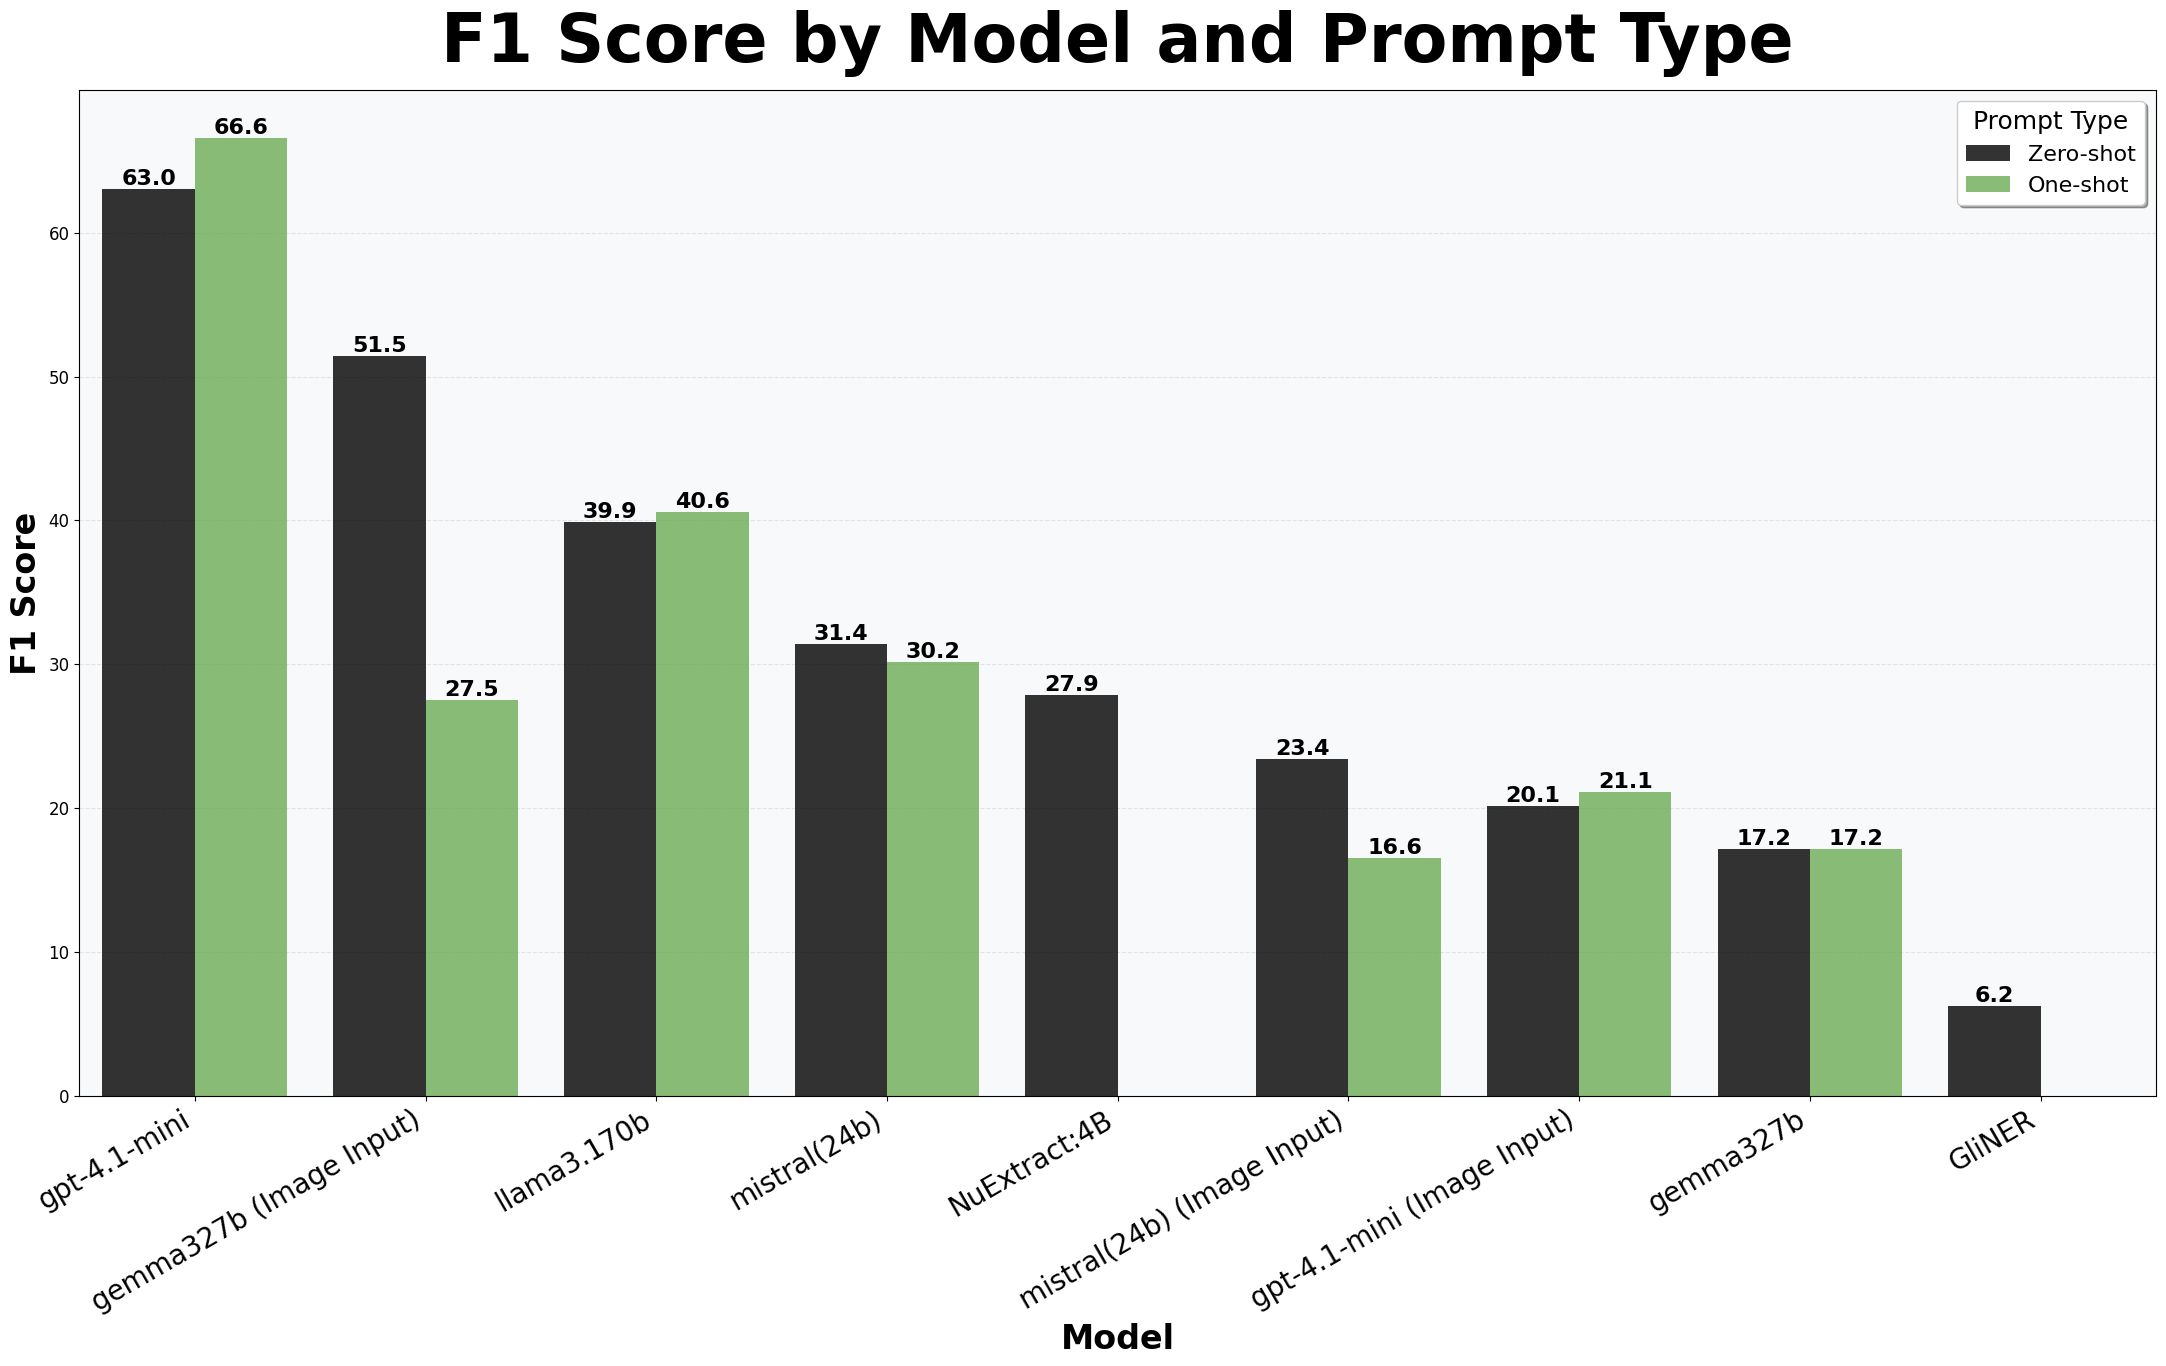


Model Performance Summary:
Prompt_Type                 One-shot  Zero-shot  Best_Score
Final_Model_Name                                           
gpt-4.1-mini                   66.60      63.05       66.60
gemma327b (Image Input)        27.53      51.45       51.45
llama3.170b                    40.57      39.91       40.57
mistral(24b)                   30.18      31.39       31.39
NuExtract:4B                     NaN      27.89       27.89
mistral(24b) (Image Input)     16.58      23.39       23.39
gpt-4.1-mini (Image Input)     21.13      20.13       21.13
gemma327b                      17.20      17.20       17.20
GliNER                           NaN       6.23        6.23

Color Legend:
Light Green (One-shot): LTNER/GPT-NER prompting
Dark Green (Zero-shot): Normal prompting


In [200]:
# Create improved visualization with clean model names and green color scheme
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Prepare data
df_clean = data.copy()

# Clean up model names and create proper groupings
df_clean['Model_Base'] = df_clean['LLM'].str.replace('*ImageInput*', '').str.replace(' (One-shot)', '').str.replace(' (Zero-shot)', '')
df_clean['Input_Type'] = df_clean['LLM'].apply(lambda x: 'Image Input' if '*ImageInput*' in x else 'Text Input')
df_clean['Prompt_Type'] = df_clean['Prompt'].map({
    'LTNER/GPT-NER': 'One-shot',
    'Normal': 'Zero-shot',
    'None': 'Zero-shot'
})

# Create final model name with input type indicator
df_clean['Final_Model_Name'] = df_clean.apply(
    lambda row: f"{row['Model_Base']} (Image Input)" if row['Input_Type'] == 'Image Input' else row['Model_Base'],
    axis=1
)

# Filter out None prompts and group by model and prompt type
df_filtered = df_clean[df_clean['Prompt_Type'] != 'None']
model_prompt_stats = df_filtered.groupby(['Final_Model_Name', 'Prompt_Type']).F1score.mean().reset_index()

# Sort models by best performance
model_order = model_prompt_stats.groupby('Final_Model_Name')['F1score'].max().sort_values(ascending=False).index

# Define green color palette
green_colors = {'One-shot': '#64BB46', 'Zero-shot': "#000000"}  # green and black 

# Create the plot
plt.figure(figsize=(22, 14))
ax = sns.barplot(
    data=model_prompt_stats,
    x='Final_Model_Name',
    y='F1score',
    hue='Prompt_Type',
    order=model_order,
    palette=green_colors,
    alpha=0.8
)

# Customize the plot
plt.title('F1 Score by Model and Prompt Type',
         fontsize=48, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=24, fontweight='bold')
plt.ylabel('F1 Score', fontsize=24, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=20)
plt.yticks(fontsize=12)

# Add F1 score labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', fontsize=16, fontweight='bold')

# Customize legend
plt.legend(title='Prompt Type', title_fontsize=18, fontsize=16,
          loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Set clean background
ax.set_facecolor('#f8f9fa')
plt.tight_layout()
plt.show()

# Print summary statistics
print('\nModel Performance Summary:')
print('=' * 50)
summary_table = model_prompt_stats.pivot(index='Final_Model_Name', columns='Prompt_Type', values='F1score')
summary_table['Best_Score'] = summary_table.max(axis=1)
summary_table = summary_table.sort_values('Best_Score', ascending=False)
print(summary_table.round(2))

print('\nColor Legend:')
print('Light Green (One-shot): LTNER/GPT-NER prompting')
print('Dark Green (Zero-shot): Normal prompting')